In [32]:
# This Notebook is for experimenting with features & trying to improve boosting models
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score
pd.set_option('display.max_columns', None)
import joblib
import torch

pet_df = pd.read_csv("../data/train/train.csv") #Beware of directory

In [ ]:
# TODO: lookup sentiment
# TODO: text feature (TF-IDF)
# Target encoding
def featurize_table(data_df, tfidf_vectorizer=None, is_train=True):
    tabular_df = data_df.copy()
    # Namelength
    tabular_df["name_length"] = tabular_df['Name'].str.len().fillna(0)
    
    # Description length
    tabular_df['description_length'] = tabular_df['Description'].str.len().fillna(0)
    
    # Is Mixed Breed? (Breed2 is not 0)
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0).astype(int)
    
    
    
    # 1. Text
    tabular_df['word_count'] = tabular_df['Description'].str.split().str.len().fillna(0)
    tabular_df['char_count'] = tabular_df['Description'].str.len().fillna(0)
    tabular_df['avg_word_len'] = tabular_df['char_count'] / (tabular_df['word_count'] + 1)
    tabular_df['num_digits'] = tabular_df['Description'].apply(lambda x: sum(c.isdigit() for c in str(x)))
    tabular_df['all_caps_ratio'] = tabular_df['Description'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(1, len(str(x))))

    # 2. Measures
    tabular_df['fee_per_pet'] = tabular_df['Fee'] / tabular_df['Quantity'].replace(0,1)
    tabular_df['photo_per_pet'] = tabular_df['PhotoAmt'] / tabular_df['Quantity']
    tabular_df['age_per_size'] = tabular_df['Age'] / tabular_df['MaturitySize'] # Needs careful handling of 0s
    tabular_df['total_media'] = tabular_df['PhotoAmt'] + tabular_df['VideoAmt'] # Total Media (Engagement proxy)
    tabular_df['num_colors'] = (tabular_df[['Color1', 'Color2', 'Color3']] != 0).sum(axis=1) # Number of Colors (Count non-zero color columns)
    
    
    # 3. Simple Interactions
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0) & (tabular_df['Breed2'].notnull())
    tabular_df['is_specific_color'] = (tabular_df['Color2'] != 0) # Has more than 1 color    
    tabular_df['is_free'] = (tabular_df['Fee'] == 0).astype(int)    # Is Free? (Fee is 0)
    tabular_df['has_health_issue'] = (tabular_df['Health'] > 1).astype(int)   # Health Issue Flag (Health > 1 implies injury or condition)
    
    # log transform for shit and giggles
    tabular_df['Fee'] = np.log1p(tabular_df['Fee'])
    tabular_df['PhotoAmt'] = np.log1p(tabular_df['PhotoAmt'])
    
    # Drop useless features -> does this actually works?
    features_to_drop = [""]
    
    # Encode categories
    cat_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
                    'Sterilized', 'Health', 'State']
    for col in cat_cols:
        if col in tabular_df.columns:
            tabular_df[col] = tabular_df[col].astype('category')
        

    tabular_df.drop(['Name', 'PetID', 'Description', "RescuerID"], axis=1, inplace=True)
    return tabular_df

pet_features = featurize_table(pet_df)
pet_features.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,name_length,description_length,is_mixed_breed,word_count,char_count,avg_word_len,num_digits,all_caps_ratio,fee_per_pet,photo_per_pet,age_per_size,total_media,num_colors,is_specific_color,is_free,has_health_issue
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2,6.0,359.0,False,69.0,359.0,5.128571,1,0.019499,100.0,1.0,3.0,1.0,2,True,0,0
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0,11.0,118.0,False,23.0,118.0,4.916667,0,0.025424,0.0,2.0,0.5,2.0,2,True,1,0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3,6.0,393.0,False,69.0,393.0,5.614286,0,0.022901,0.0,7.0,0.5,7.0,2,True,1,0
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2,4.0,146.0,False,25.0,146.0,5.615385,0,0.006849,150.0,8.0,2.0,8.0,2,True,0,0
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2,6.0,390.0,False,81.0,390.0,4.756098,0,0.020513,0.0,3.0,0.5,3.0,1,False,1,0


In [34]:
# Splitting the data from train.csv
X = pet_features.drop(['AdoptionSpeed'], axis=1)
y = pet_features['AdoptionSpeed'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,name_length,description_length,is_mixed_breed,word_count,char_count,avg_word_len,num_digits,all_caps_ratio,fee_per_pet,photo_per_pet,age_per_size,total_media,num_colors,is_specific_color,is_free,has_health_issue
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,6.0,359.0,False,69.0,359.0,5.128571,1,0.019499,100.0,1.0,3.0,1.0,2,True,0,0
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,11.0,118.0,False,23.0,118.0,4.916667,0,0.025424,0.0,2.0,0.5,2.0,2,True,1,0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,6.0,393.0,False,69.0,393.0,5.614286,0,0.022901,0.0,7.0,0.5,7.0,2,True,1,0
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,4.0,146.0,False,25.0,146.0,5.615385,0,0.006849,150.0,8.0,2.0,8.0,2,True,0,0
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,6.0,390.0,False,81.0,390.0,4.756098,0,0.020513,0.0,3.0,0.5,3.0,1,False,1,0


In [ ]:
# Hyperparameter-tuning w/Optuna
import optuna
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
import torch
def objective(trial):
    params = {
        # Config for how to predict
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 5,
        'tree_method': 'hist', # Faster training
        'enable_categorical': True,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # % of feature used per tree
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set (futher split from train set)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, 
                                                stratify=y_train
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBClassifier(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, preds, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = 5

xgb_optuna = xgb.XGBClassifier(**best_params)
xgb_optuna.fit(X_train, y_train) 
pred_xgb = xgb_optuna.predict(X_test)
#joblib.dump(xgb_optuna, 'xgb_optuna_full.pkl')

[I 2026-02-17 03:42:37,633] A new study created in memory with name: no-name-e8af64e0-0527-4a9f-9bd4-8b063774a9ad
[I 2026-02-17 03:42:44,269] Trial 0 finished with value: 0.3624364203647261 and parameters: {'n_estimators': 875, 'learning_rate': 0.016310364565855846, 'max_depth': 11, 'subsample': 0.8660952532013193, 'colsample_bytree': 0.9236102346637336, 'min_child_weight': 4, 'reg_alpha': 5.728011582323212, 'reg_lambda': 5.873503155576955}. Best is trial 0 with value: 0.3624364203647261.
[I 2026-02-17 03:42:45,907] Trial 1 finished with value: 0.3730320843646947 and parameters: {'n_estimators': 354, 'learning_rate': 0.054345216641689856, 'max_depth': 6, 'subsample': 0.9357861849468998, 'colsample_bytree': 0.7837714036262988, 'min_child_weight': 7, 'reg_alpha': 5.728799561576401, 'reg_lambda': 9.758725216340343}. Best is trial 1 with value: 0.3730320843646947.
[I 2026-02-17 03:42:48,565] Trial 2 finished with value: 0.32862895483074184 and parameters: {'n_estimators': 345, 'learning_ra

Best trial value: 0.3731837140288038
Best params: {'n_estimators': 784, 'learning_rate': 0.07836581018985941, 'max_depth': 8, 'subsample': 0.8380608013822534, 'colsample_bytree': 0.8487121166681929, 'min_child_weight': 7, 'reg_alpha': 8.14062500128292, 'reg_lambda': 6.916167238570465}


In [36]:
# Hyperparameter-tuning w/Optuna (Regressor)
import optuna
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
import torch
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        #'num_class': 5,
        'tree_method': 'hist', # Faster training
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, 
                                                stratify=y_train
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # FIXED: Round continuous predictions to integers for Kappa calculation
    preds = model.predict(X_val)
    preds_rounded = np.rint(preds).astype(int).clip(0, 4) 
    kappa = cohen_kappa_score(y_val, preds_rounded, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'reg:squarederror'

xgb_optuna_reg = xgb.XGBRegressor(**best_params)
xgb_optuna_reg.fit(X_train, y_train) 
pred_xgb_reg_raw = xgb_optuna_reg.predict(X_test)
pred_xgb_reg = np.rint(pred_xgb_reg_raw).astype(int).clip(0, 4)
#joblib.dump(xgb_optuna_reg, 'xgb_optuna_reg_full.pkl')

[I 2026-02-17 03:44:39,006] A new study created in memory with name: no-name-8b46bf7c-5e09-4eee-ad6a-6245eb5cf35d
[I 2026-02-17 03:44:39,705] Trial 0 finished with value: 0.2733150957473265 and parameters: {'n_estimators': 778, 'learning_rate': 0.01335795861808024, 'max_depth': 3, 'subsample': 0.8270235176884443, 'colsample_bytree': 0.6702764470418224, 'min_child_weight': 4, 'reg_alpha': 4.533843950511849, 'reg_lambda': 5.9462941653534}. Best is trial 0 with value: 0.2733150957473265.
[I 2026-02-17 03:44:40,746] Trial 1 finished with value: 0.2828704841484394 and parameters: {'n_estimators': 574, 'learning_rate': 0.009757626504599813, 'max_depth': 7, 'subsample': 0.9615709462607, 'colsample_bytree': 0.9423664571080428, 'min_child_weight': 5, 'reg_alpha': 0.02129893406785932, 'reg_lambda': 4.115349454257478}. Best is trial 1 with value: 0.2828704841484394.
[I 2026-02-17 03:44:41,123] Trial 2 finished with value: 0.3060532377783466 and parameters: {'n_estimators': 806, 'learning_rate': 0

Best trial value: 0.32620729146783745
Best params: {'n_estimators': 680, 'learning_rate': 0.018914455292008255, 'max_depth': 9, 'subsample': 0.602965159853735, 'colsample_bytree': 0.7749896017656499, 'min_child_weight': 10, 'reg_alpha': 3.216682612122989, 'reg_lambda': 2.726944337090733}


# Evaluate

In [40]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

def evaluate_model(model, model_prediction):
    print(f"Model: {model.__class__.__name__}")
    print(f"Kappa Score: {cohen_kappa_score(model_prediction, y_test, weights='quadratic'):.4f}")
    print(f"Accuracy Score: {accuracy_score(model_prediction, y_test):.4f}")
   
print (evaluate_model(xgb_optuna, pred_xgb))

print (evaluate_model(xgb_optuna_reg, pred_xgb_reg))

Model: XGBClassifier
Kappa Score: 0.3463
Accuracy Score: 0.4165
None
Model: XGBRegressor
Kappa Score: 0.3213
Accuracy Score: 0.3174
None


<Figure size 1200x600 with 0 Axes>

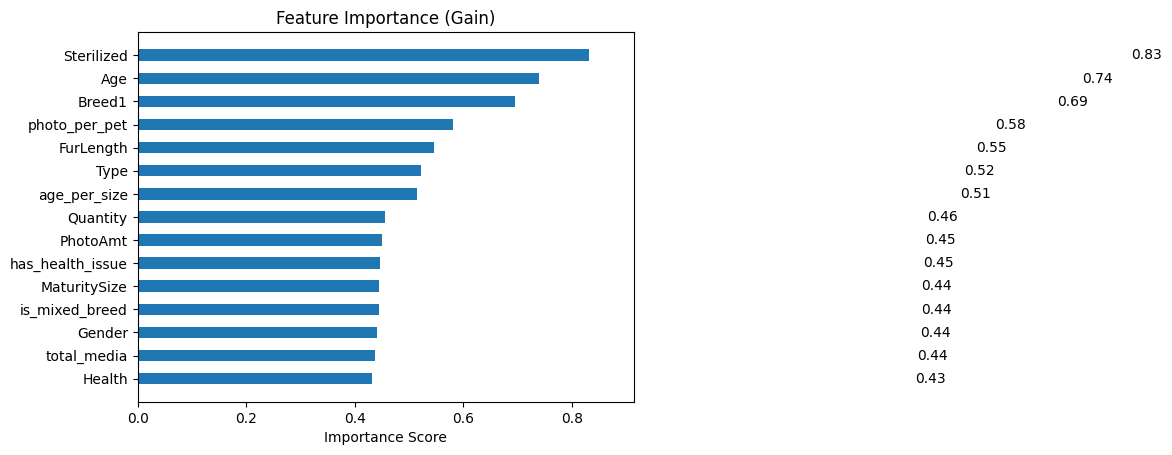

<Figure size 1200x600 with 0 Axes>

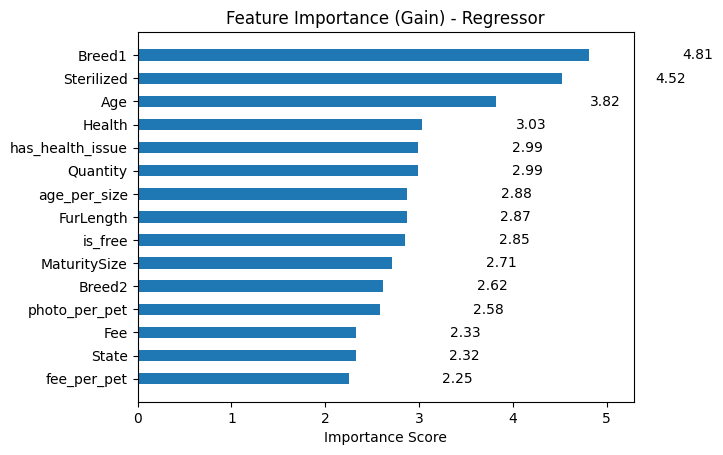

In [38]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_optuna.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_optuna, max_num_features=15, height=0.5, importance_type="gain", values_format = "{v:.2f}") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()
# Also plot for the regressor model
xgb_optuna_reg.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_optuna_reg, max_num_features=15, height=0.5, importance_type="gain", values_format="{v:.2f}")
plt.title("Feature Importance (Gain) - Regressor")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()

In [39]:
# Get feature importance from the classifier model
importance_dict = xgb_optuna.get_booster().get_score(importance_type='gain')

# Sort by importance (ascending to get the least important features)
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1])

# Get bottom 5 features
bottom_5 = sorted_importance[:5]

print("Bottom 5 least important features (by gain):")
for feature, importance in bottom_5:
    print(f"{feature}: {importance:.4f}")

Bottom 5 least important features (by gain):
Color2: 0.3416
is_free: 0.3501
num_colors: 0.3533
Color3: 0.3558
VideoAmt: 0.3571
